Build an uncertainty model and summarize local uncertainty.For all, defend parameter selection, model choices and only show a couple realizations at most, along with the local uncertainty maps.

1.Calculate the uncertainty in facies proportions and average porosity with bootstrap.Use 'n effective', instead of 'n' to account for spatial continuity.

2.Propagate the uncertainty in facies proportions and porosity average to porosity realizations.

3.Calculate and summarize the local uncertainty in oil in place.Assume the same constants as update #2, thickness of 20m and oil saturation of 90\%.Include the local P10, expectation and P90 maps.

In [15]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.
import scipy
import random

In [2]:
class Univariate():
    def __init__(self,welldata):
        self.filename = welldata # set filename
        self.welldata = pd.read_csv(welldata) # read well data into dataframe
        #self.sandstone = self.welldata.loc[(data.welldata['Facies'] == 1)] # Group by facies (Sandstone)
        #self.shale = self.welldata.loc[(data.welldata['Facies'] == 0)] # Group by facies (Shale)

        
    def comp_outliers(self,dataframe,metric):
        # computes the upper and lower fence based on Tukey 1.5 x IQR method and returns an array of format 
        # [lower_fence,upper_fence]
        P25 = np.percentile(dataframe[metric].values,25)
        P75 = np.percentile(dataframe[metric].values,75)
        lower_fence = P25 - 1.5*(P75-P25)
        upper_fence = P75 + 1.5*(P75-P25)
        if lower_fence < 0.0:
            lower_fence = 0.0
        return [lower_fence,upper_fence]
    
    def remove_outliers(self,dataframe,metric):
        # removes outliers from dataframe and returns new dataframe without outliers
        bounds = self.comp_outliers(dataframe,metric)
        cleaned_data = dataframe.loc[(dataframe[metric] >= bounds[0]) & (dataframe[metric] <= bounds[1])]
        return cleaned_data 

In [64]:
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [68]:
# defining Variogram Model code
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
                cov1 = pmx - cc[js] * (h ** aa[js])
                cova2_ = cova2_ + cov1
    return cova2_

def vmodel(
    nlag,
    xlag,
    azm,
    vario
):
    """GSLIB's VMODEL program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Mar, 2019).
    :param nlag: number of variogram lags 
    :param xlag: size of the lags
    :param axm: direction by 2D azimuth, 000 is y positive, 090 is x positive 
    :param vario: dictionary with the variogram parameters
    :return:
    """
    
# Parameters
    MAXNST=4
    DEG2RAD=3.14159265/180.0 
    MAXROT=MAXNST+1
    EPSLON = 1.0e-20
    VERSION= 1.01
  
# Declare arrays
    index = np.zeros(nlag+1)
    h = np.zeros(nlag+1)
    gam = np.zeros(nlag+1)
    cov = np.zeros(nlag+1)
    ro = np.zeros(nlag+1)
    
# Load the variogram
    nst = vario["nst"]
    cc = np.zeros(nst)
    aa = np.zeros(nst)
    it = np.zeros(nst)
    ang = np.zeros(nst)
    anis = np.zeros(nst)
    
    c0 = vario["nug"]
    cc[0] = vario["cc1"]
    it[0] = vario["it1"]
    ang[0] = vario["azi1"]
    aa[0] = vario["hmaj1"]
    anis[0] = vario["hmin1"] / vario["hmaj1"]
    if nst == 2:
        cc[1] = vario["cc2"]
        it[1] = vario["it2"]
        ang[1] = vario["azi2"]
        aa[1] = vario["hmaj2"]
        anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
    xoff = math.sin(DEG2RAD*azm)*xlag
    yoff = math.cos(DEG2RAD*azm)*xlag
    print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
    rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
    xx = 0.0; yy = 0.0      
    for il in range(0,nlag+1):
        index[il] = il
        cov[il] = cova2(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
        gam[il] = maxcov - cov[il]
        ro[il]  = cov[il]/maxcov
        h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
        xx = xx + xoff
        yy = yy + yoff

# finished
    return index,h,gam,cov,ro

In [3]:
# load original csv file
data = Univariate('1_sample_data.csv')
# doing facies separation and outlier removal
# pulling out the raw facies data
Sandstone_raw = data.welldata.loc[(data.welldata['Facies'] == 1)]
Shale_raw = data.welldata.loc[(data.welldata['Facies'] == 0)]
# outlier removal for sandstone (porosity, permeability, acoustic impedance)
Sandstone_cleaned_por = data.remove_outliers(Sandstone_raw,'Porosity')
Sandstone_cleaned_por_perm = data.remove_outliers(Sandstone_cleaned_por,'Perm')
Sandstone_final = data.remove_outliers(Sandstone_cleaned_por_perm,'AI')
# outlier removal for shale (porosity, permeability, acoustic impedance)
Shale_cleaned_por = data.remove_outliers(Shale_raw,'Porosity')
Shale_cleaned_por_perm = data.remove_outliers(Shale_cleaned_por,'Perm')
Shale_final = data.remove_outliers(Shale_cleaned_por_perm,'AI')
# combining facies for total 'cleaned' dataset
df = pd.concat([Sandstone_final,Shale_final])
del df['Unnamed: 0']

In [4]:
# functions for spatial bootstrap
from numba import jit # for numerical speed up

@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.14159265
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff
    

### 1a. Uncertainty in facies proportions using spatial bootstrap

In [44]:
# indicator variogram for facies from update 4
nug = 0.1                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 2; it2 = 3            # defining types of model variograms 1=spherical, 2=exponential, 3=Gaussian
cc1 = 0.7; cc2 = 0.2       # defining contributions of each structure
azi1 = 112.5; azi2 = 112.5     # defining major azimuthal direction
hmaj1 = 250; hmaj2 = 500     # defining range in major direction
hmin1 = 200; hmin2 = 220     # defining range in minor direction

# appending variograms to list to be consistent with demo workflow
# for 2 facies the indicator variograms for sand and shale are the same
vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)

In [45]:
# calculating n_effective
n_eff = n_effective(df,'X','Y',seed=1,nreal=1000,vario=vario)
print('Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data = 17.74 / 217.


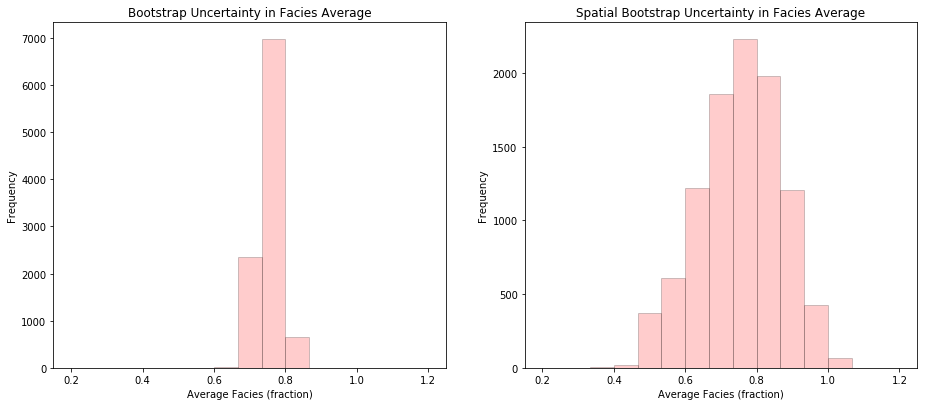

In [50]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
facies_mean = np.zeros(L); spatial_mean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=len(df))
    spatial_samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=int(n_eff))

    facies_mean[l] = np.average(samples)
    spatial_mean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(facies_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Bootstrap Uncertainty in Facies Average')

plt.subplot(122)
GSLIB.hist_st(spatial_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Spatial Bootstrap Uncertainty in Facies Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   

### 1b. Uncertainty in average porosity using spatial bootstrap

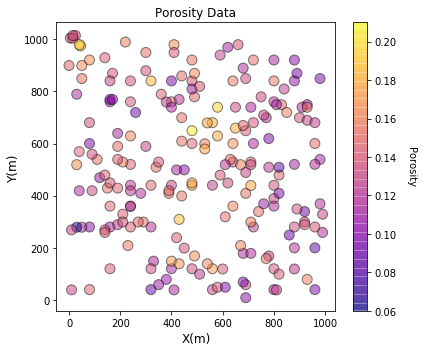

In [55]:
# visualize the porosity data
pormin = 0.06; pormax = 0.21
plt.figure(figsize=(6,5))
im = plt.scatter(df['X'],df['Y'],s=100,c=df['Porosity'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=pormin,
                 vmax=pormax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Porosity Data', size=12)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Porosity',rotation=270,labelpad=20,size=10)
plt.tight_layout()
plt.show()

In [56]:
# decluster porosity data
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame

There are 217 data with:
   mean of      0.13536741338554403 
   min and max  0.0606929054762965 and 0.20438817014234475
   standard dev 0.024034484994892254 


In [58]:
# sparse porosity matrix
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma # plotting parameters
por_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Porosity',xmin, xmax, ymin, ymax, step=10.0)

We have made a kernel of size, number of grid cells (ny, nx) (39, 39)


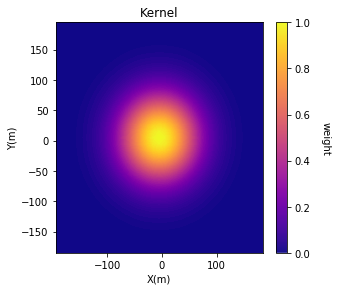

In [59]:
# gaussian kernel trend
kernel_size = 39
gaus_std = 5
gkern1d = signal.gaussian(kernel_size,gaus_std).reshape(kernel_size, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

csize = 10.0
plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=(-1 * kernel_size/2 * 10),xmax=(kernel_size/2 * 10),
                  ymin=(-1 * kernel_size/2 * 10),ymax=(kernel_size/2 * 10),
                  step=csize,vmin=0,vmax=1,
                  title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

porosity_trend = convolve(por_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

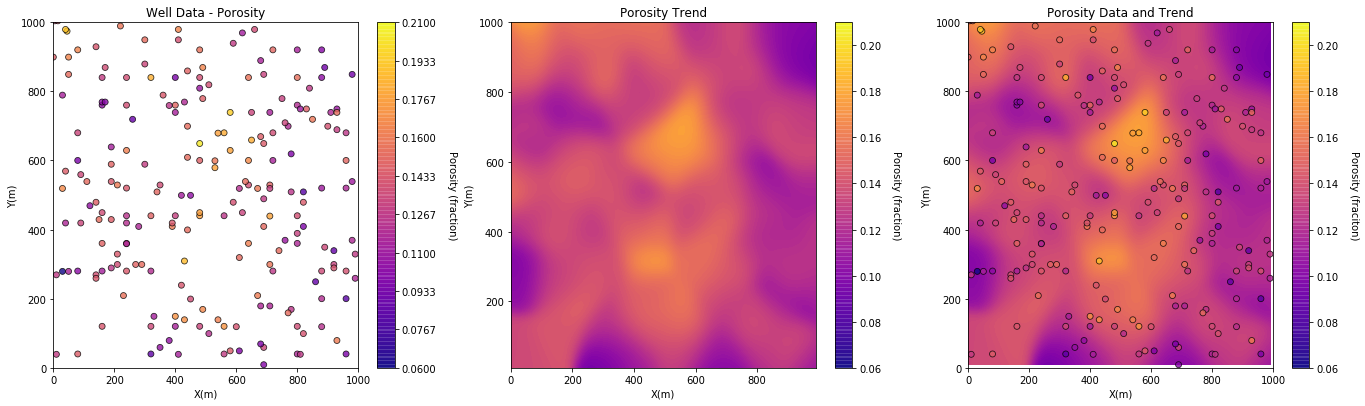

In [60]:
# visualizing data and trend in porosity
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,
                'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(132)
GSLIB.pixelplt_st(porosity_trend,xmin,xmax,ymin,ymax,csize,pormin,pormax,
                  'Porosity Trend','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(133)
GSLIB.locpix_st(porosity_trend,xmin,xmax,ymin,ymax,csize,pormin,pormax,df,
                'X','Y','Porosity','Porosity Data and Trend','X(m)','Y(m)','Porosity (fraciton)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [61]:
# add trend to dataframe -- removing trend from data
df = GSLIB.sample(porosity_trend,xmin,ymin,csize,"Por_Trend",df,'X','Y')
df['Por_Res'] = df['Porosity'] - df['Por_Trend'] # calculate the residual and add to DataFrame

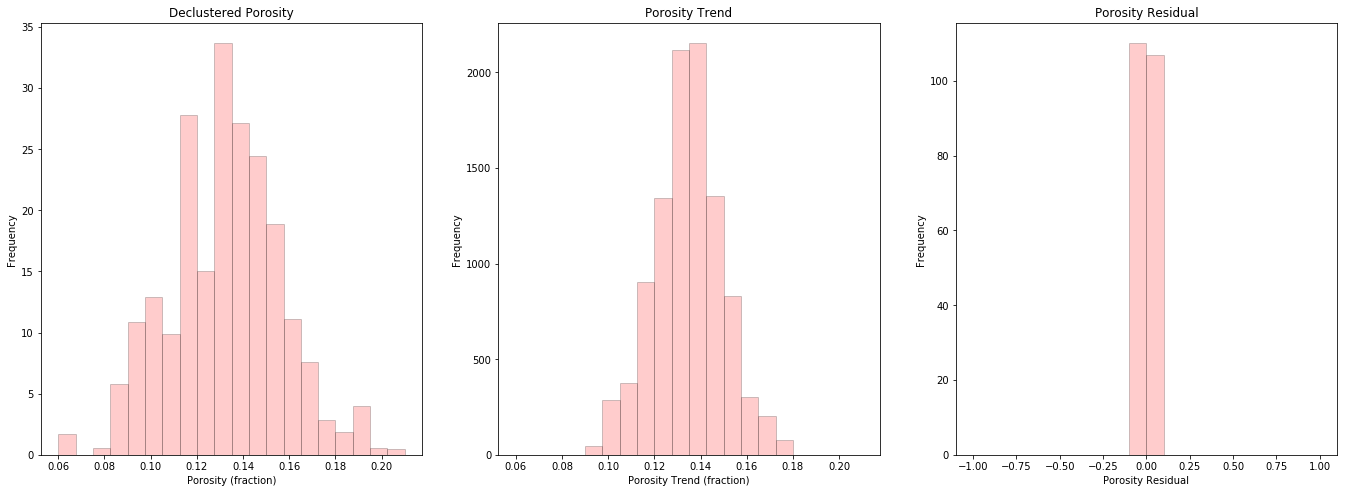

In [62]:
# check histogram to trend
plt.subplot(131)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,
              df['Wts'],'Porosity (fraction)','Declustered Porosity')

plt.subplot(132)
GSLIB.hist_st(porosity_trend.flatten(),pormin,pormax,False,False,20,None,
              'Porosity Trend (fraction)','Porosity Trend')

plt.subplot(133)
GSLIB.hist_st(df['Por_Res'],-1,1,False,False,20,None,
             'Porosity Residual','Porosity Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

In [65]:
# check portion of variance modeled by trend
wavg_por,wstd_por = weighted_avg_and_std(df['Porosity'],df['Wts']) 

wavg_por_trend = np.average(porosity_trend)
wstd_por_trend = np.std(porosity_trend)

print('Declustered Porosity Data: Average ' + str(round(wavg_por,4)) + ', Var ' + str(round(wstd_por**2,5)))
print('Porosity Trend: Average            ' + str(round(wavg_por_trend,4)) + ', Var ' + str(round(wstd_por_trend**2,5)))
print('Proportion Trend / Known:          ' + str(round(wstd_por_trend**2/(wstd_por**2),3)))
print('Proportion Residual / Unknown:     ' + str(round((wstd_por**2 - wstd_por_trend**2)/(wstd_por**2),3)))

Declustered Porosity Data: Average 0.132, Var 0.00058
Porosity Trend: Average            0.1346, Var 0.00022
Proportion Trend / Known:          0.38
Proportion Residual / Unknown:     0.62


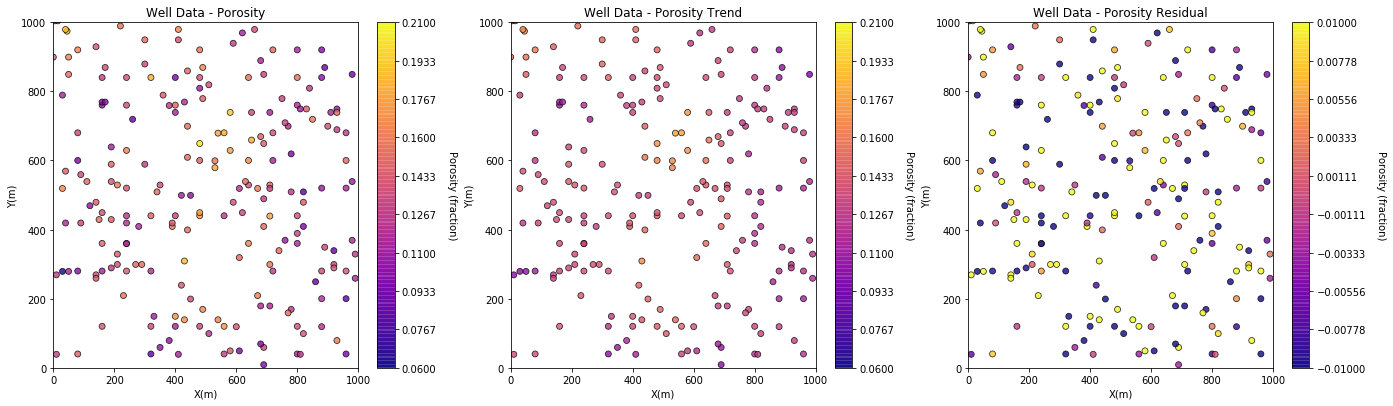

In [66]:
# plot data, trend and residuals
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,
                'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(132)
GSLIB.locmap_st(df,'X','Y','Por_Trend',xmin,xmax,ymin,ymax,pormin,pormax,
                'Well Data - Porosity Trend','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(133)
GSLIB.locmap_st(df,'X','Y','Por_Res',xmin,xmax,ymin,ymax,-0.01,0.01,
                'Well Data - Porosity Residual','X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

 x,y,z offsets = 3.5355339154516137,-3.5355338964138614
 x,y,z offsets = 3.535533902759779,3.5355339091056965


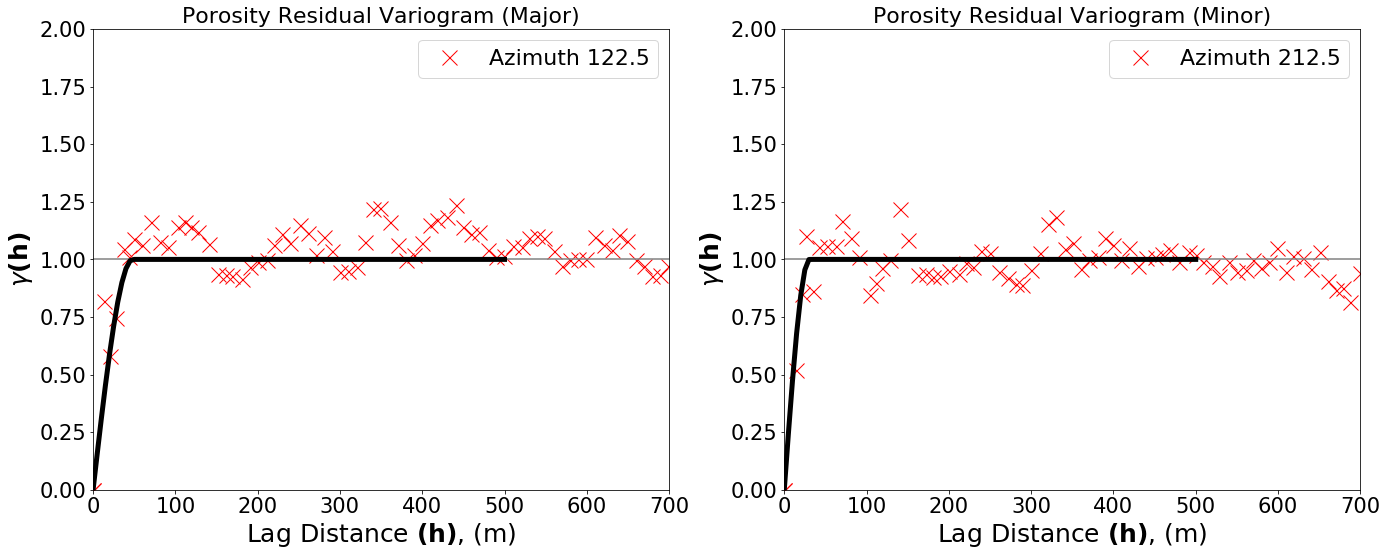

In [95]:
# modeling variogram for porosity residuals

# recompute experimental variogram
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 10.0; lag_tol = 20.0; nlag = 75;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
azi_mat = [122.5, 212.5]                             # major and minor directions

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(df,"X","Y","Por_Res",
                                                  tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(df,"X","Y","Por_Res",
                                                  tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.0                    # defining nugget effect
nst = 1                      # defining number of nested structures
it1 = 1;                     # defining types of model variograms
cc1 = 1.0;                   # defining contributions of each structure
azi1 = azi_mat[0];                  # defining major azimuthal direction
hmaj1 = 50;                 # defining range in major direction
hmin1 = 30;                  # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)
nlag = 100; xlag = 5; azm = 135.0; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 45.0
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Porosity Residual Variogram (Major)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,2.0])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper right',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Porosity Residual Variogram (Minor)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,2.0])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

In [96]:
# calculating n_effective
n_eff = n_effective(df,'X','Y',seed=1,nreal=1000,vario=vario)
print('Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data = 162.51 / 217.


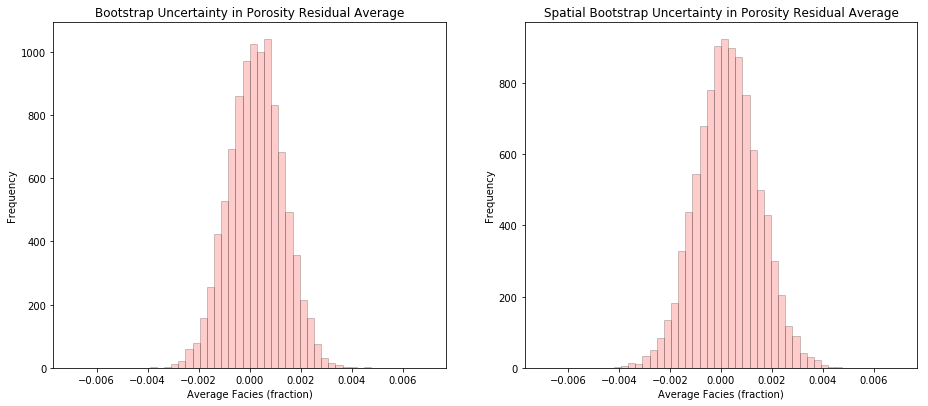

In [112]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
porosity_mean = np.zeros(L); spatial_mean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df['Por_Res'].values, weights=None, cum_weights=None, k=len(df))
    spatial_samples = random.choices(df['Por_Res'].values, weights=None, cum_weights=None, k=int(n_eff))

    porosity_mean[l] = np.average(samples)
    spatial_mean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(porosity_mean,-0.007,0.007,False,False,50,None,
              'Average Facies (fraction)','Bootstrap Uncertainty in Porosity Residual Average')

plt.subplot(122)
GSLIB.hist_st(spatial_mean,-0.007,0.007,False,False,50,None,
              'Average Facies (fraction)','Spatial Bootstrap Uncertainty in Porosity Residual Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   

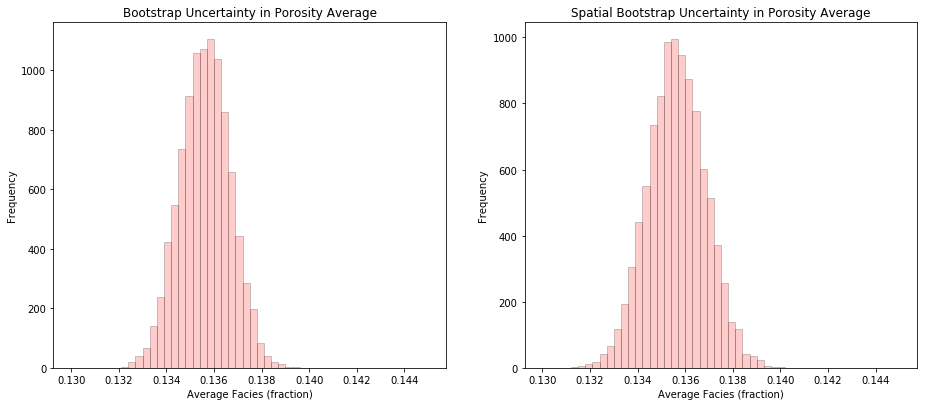

In [122]:
# scale residuals up by the porosity data mean
data_por_mean = df['Porosity'].mean()
por_mean = porosity_mean + data_por_mean
spa_mean = spatial_mean + data_por_mean
plt.subplot(121)
GSLIB.hist_st(por_mean,0.13,0.145,False,False,50,None,
              'Average Facies (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(spa_mean,0.13,0.145,False,False,50,None,
              'Average Facies (fraction)','Spatial Bootstrap Uncertainty in Porosity Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show() 